In [1]:
!pip install pandas numpy scikit-learn tensorflow


In [2]:
import pandas as pd

# Baca dataset
df = pd.read_csv("dataset_ormawa_dummy_3000.csv")

# Tampilkan 5 data pertama
df.head()


,id,komentar,label
0,1,Acara ORMAWA kemarin seru sekali,positif
1,2,Kegiatan BEM sangat bermanfaat,positif
2,3,Acara ORMAWA kemarin seru sekali,positif
3,4,Acara kampus sangat terorganisir,positif
4,5,Panitia kegiatan sangat profesional,positif


In [3]:
print("Jumlah data:", len(df))
print(df['label'].value_counts())


Jumlah data: 3000
label
positif    1000
netral     1000
negatif    1000
Name: count, dtype: int64


In [4]:
import re

def clean_text(text):
    text = text.lower()                      # lowercase
    text = re.sub(r"http\S+", "", text)      # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus simbol & angka
    text = re.sub(r"\s+", " ", text)         # hapus spasi berlebih
    return text

# Terapkan preprocessing
df['clean_komentar'] = df['komentar'].apply(clean_text)

# Lihat hasil
df[['komentar','clean_komentar']].head()


,komentar,clean_komentar
0,Acara ORMAWA kemarin seru sekali,acara ormawa kemarin seru sekali
1,Kegiatan BEM sangat bermanfaat,kegiatan bem sangat bermanfaat
2,Acara ORMAWA kemarin seru sekali,acara ormawa kemarin seru sekali
3,Acara kampus sangat terorganisir,acara kampus sangat terorganisir
4,Panitia kegiatan sangat profesional,panitia kegiatan sangat profesional


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

df[['label','label_encoded']].head()


,label,label_encoded
0,positif,2
1,positif,2
2,positif,2
3,positif,2
4,positif,2


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_komentar'])

X = tokenizer.texts_to_sequences(df['clean_komentar'])
X = pad_sequences(X, maxlen=50)

y = df['label_encoded']


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6727 - loss: 0.8563 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 7.1290e-04
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.5343e-04
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 8.3484e-04 - val_accuracy: 1.0000 - val_loss: 3.1224e-04


In [12]:
loss, acc = model.evaluate(X_test, y_test)
print("Akurasi:", acc)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.9929e-04
Akurasi: 1.0


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prediksi data test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Confusion Matrix:
 [[186   0   0]
 [  0 197   0]
 [  0   0 217]]

Classification Report:

              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00       186
      netral       1.00      1.00      1.00       197
     positif       1.00      1.00      1.00       217

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [14]:
def predict_sentiment(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=50)
    pred = model.predict(pad)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

# Coba prediksi
kalimat = "Kegiatan BEM kemarin sangat bermanfaat"
hasil = predict_sentiment(kalimat)

print("Kalimat:", kalimat)
print("Prediksi sentimen:", hasil)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Kalimat: Kegiatan BEM kemarin sangat bermanfaat
Prediksi sentimen: positif


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_bilstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_bilstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6598 - loss: 0.8869 - val_accuracy: 1.0000 - val_loss: 0.0224
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 8.0031e-04
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 5.5174e-04


In [17]:
loss_bi, acc_bi = model_bilstm.evaluate(X_test, y_test)
print("Akurasi BiLSTM:", acc_bi)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 5.3062e-04
Akurasi BiLSTM: 1.0


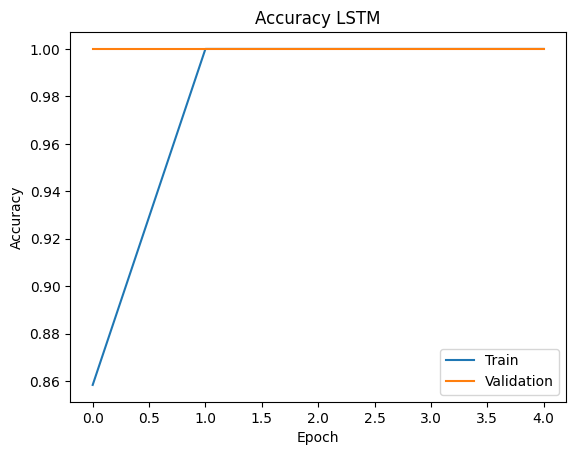

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy LSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


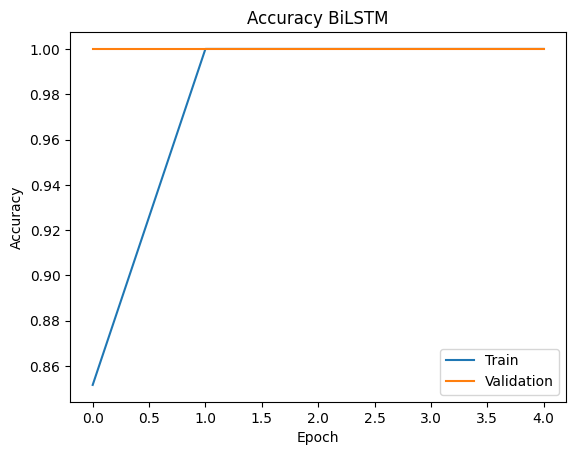

In [19]:
plt.figure()
plt.plot(history_bilstm.history['accuracy'])
plt.plot(history_bilstm.history['val_accuracy'])
plt.title('Accuracy BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


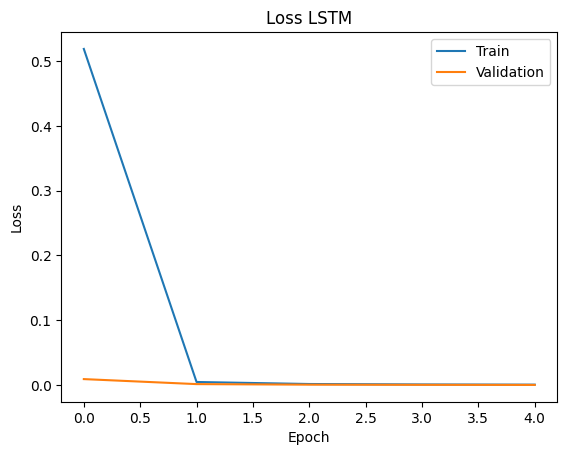

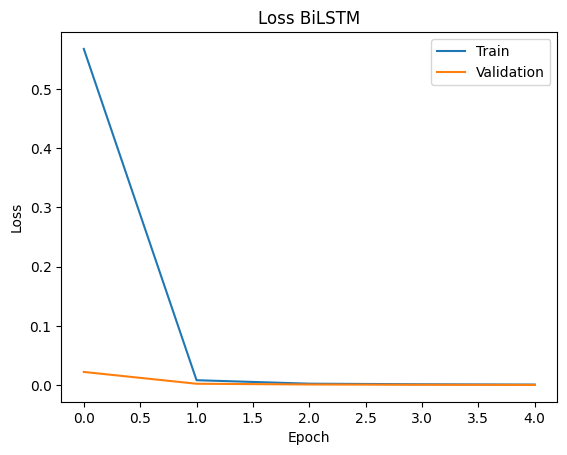

In [20]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

plt.figure()
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('Loss BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [21]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

model_cnn_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=50),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    LSTM(64),
    Dropout(0.3),

    Dense(3, activation='softmax')
])

model_cnn_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_cnn = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7358 - loss: 0.8606 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 6.0023e-04
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 1.0000 - loss: 8.5931e-04 - val_accuracy: 1.0000 - val_loss: 3.6271e-04
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 5.2662e-04 - val_accuracy: 1.0000 - val_loss: 2.4999e-04
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 4.1063e-04 - val_accuracy: 1.0000 - val_loss: 1.7855e-04


In [23]:
loss_cnn, acc_cnn = model_cnn_lstm.evaluate(X_test, y_test)
print("Akurasi CNN-LSTM:", acc_cnn)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 1.7584e-04
Akurasi CNN-LSTM: 1.0


In [24]:
import pandas as pd

hasil = {
    "Model": ["LSTM", "BiLSTM", "CNN-LSTM"],
    "Akurasi": [acc, acc_bi, acc_cnn]
}

df_hasil = pd.DataFrame(hasil)
df_hasil


,Model,Akurasi
0,LSTM,1.0
1,BiLSTM,1.0
2,CNN-LSTM,1.0
